# **DATASET: https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2**

# **Task 2 - Heart**

In [1]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!tar -xvf "/content/drive/MyDrive/Task02_Heart.tar" -C "/content/drive/MyDrive/Datasets/"

In [2]:
%cd Datasets/Task02_Heart
!ls

/content/drive/MyDrive/Datasets/Task02_Heart
dataset.json  imagesTr	labelsTr	model.py      __pycache__
dataset.py    imagesTs	lightning_logs	Preprocessed


# 1- Imports

In [2]:
!pip install nibabel celluloid torchmetrics pytorch_lightning
!pip install imgaug -U

     |████████████████████████████████| 408 kB 5.3 MB/s 
     |████████████████████████████████| 582 kB 32.1 MB/s 
     |████████████████████████████████| 596 kB 30.8 MB/s 
     |████████████████████████████████| 136 kB 31.8 MB/s 
     |████████████████████████████████| 1.1 MB 31.0 MB/s 
     |████████████████████████████████| 144 kB 31.4 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 47.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 948 kB 5.1 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albume

In [3]:
import torch
import torchvision
import torchmetrics
import cv2
import imgaug
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import pytorch_lightning as pl

from pathlib import Path
from tqdm.notebook import tqdm
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from celluloid import Camera
from IPython.display import HTML
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from dataset import CardiacDataset
from model import UNet

# 2- Preprocessing

In [4]:
root  = Path('imagesTr/')
label = Path('labelsTr/')

In [5]:
def change_img_to_lbl_path(path):
  parts = list(path.parts)
  parts[parts.index('imagesTr')] = 'labelsTr'
  return Path(*parts)

In [8]:
sample_path = list(root.glob('la*'))[0]
sample_path_lbl = change_img_to_lbl_path(sample_path)

sample_path, sample_path_lbl

(PosixPath('imagesTr/la_003.nii.gz'), PosixPath('labelsTr/la_003.nii.gz'))

In [9]:
data  = nib.load(sample_path)
label = nib.load(sample_path_lbl)

mri  = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
  plt.imshow(mri[:, :, i], cmap='bone')
  mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
  plt.imshow(mask_, alpha=0.5)
  camera.snap()

animation = camera.animate()

In [11]:
HTML(animation.to_html5_video())

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


In [4]:
def normalize(full_volume):
  mu = full_volume.mean()
  std = np.std(full_volume)
  normalized = (full_volume - mu) / std
  return normalized

def standardize(normalized):
  standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
  return standardized

In [13]:
all_files = list(root.glob('la*'))
len(all_files)

20

In [14]:
save_root = Path('Preprocessed')

for counter, path_to_mri_data in enumerate(tqdm(all_files)):

  path_to_lbl = change_img_to_lbl_path(path_to_mri_data)

  mri = nib.load(path_to_mri_data)
  assert nib.aff2axcodes(mri.affine) == ('R', 'A', 'S')

  mri_data = mri.get_fdata()
  lbl_data = nib.load(path_to_lbl).get_fdata().astype(np.uint8)

  mri_data = mri_data[32:-32, 32:-32]
  lbl_data = lbl_data[32:-32, 32:-32]

  normalized_mri_data   = normalize(mri_data)
  standardized_mri_data = standardize(normalized_mri_data)

  if counter < 17:
    current_path = save_root/'train'/str(counter)
  else:
    current_path = save_root/'val'/str(counter)

  for i in range(standardized_mri_data.shape[-1]):
    slice = standardized_mri_data[:, :, i]
    mask = lbl_data[:, :, i]
    slice_path = current_path/'data'
    mask_path = current_path/'mask'
    slice_path.mkdir(parents=True, exist_ok=True)
    mask_path.mkdir(parents=True, exist_ok=True)

    np.save(slice_path/str(i), slice)
    np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

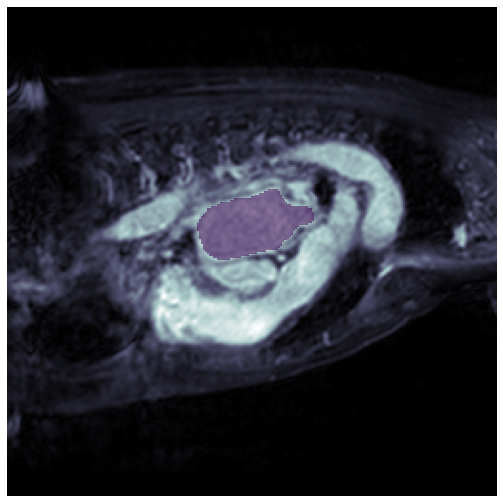

In [19]:
path  = Path('Preprocessed/train/1')
file  = '50.npy'
slice = np.load(path/'data'/file)
mask  = np.load(path/'mask'/file)

plt.figure(figsize=(9, 9))
plt.imshow(slice, cmap='bone')
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.5)
plt.axis('off')

In [5]:
seq = iaa.Sequential([iaa.Affine(scale=(0.85, 1.15),
                                 rotate=(-45, 45)),
                      iaa.ElasticTransformation()])

In [17]:
path    = Path('Preprocessed/train/')
dataset = CardiacDataset(path, seq)

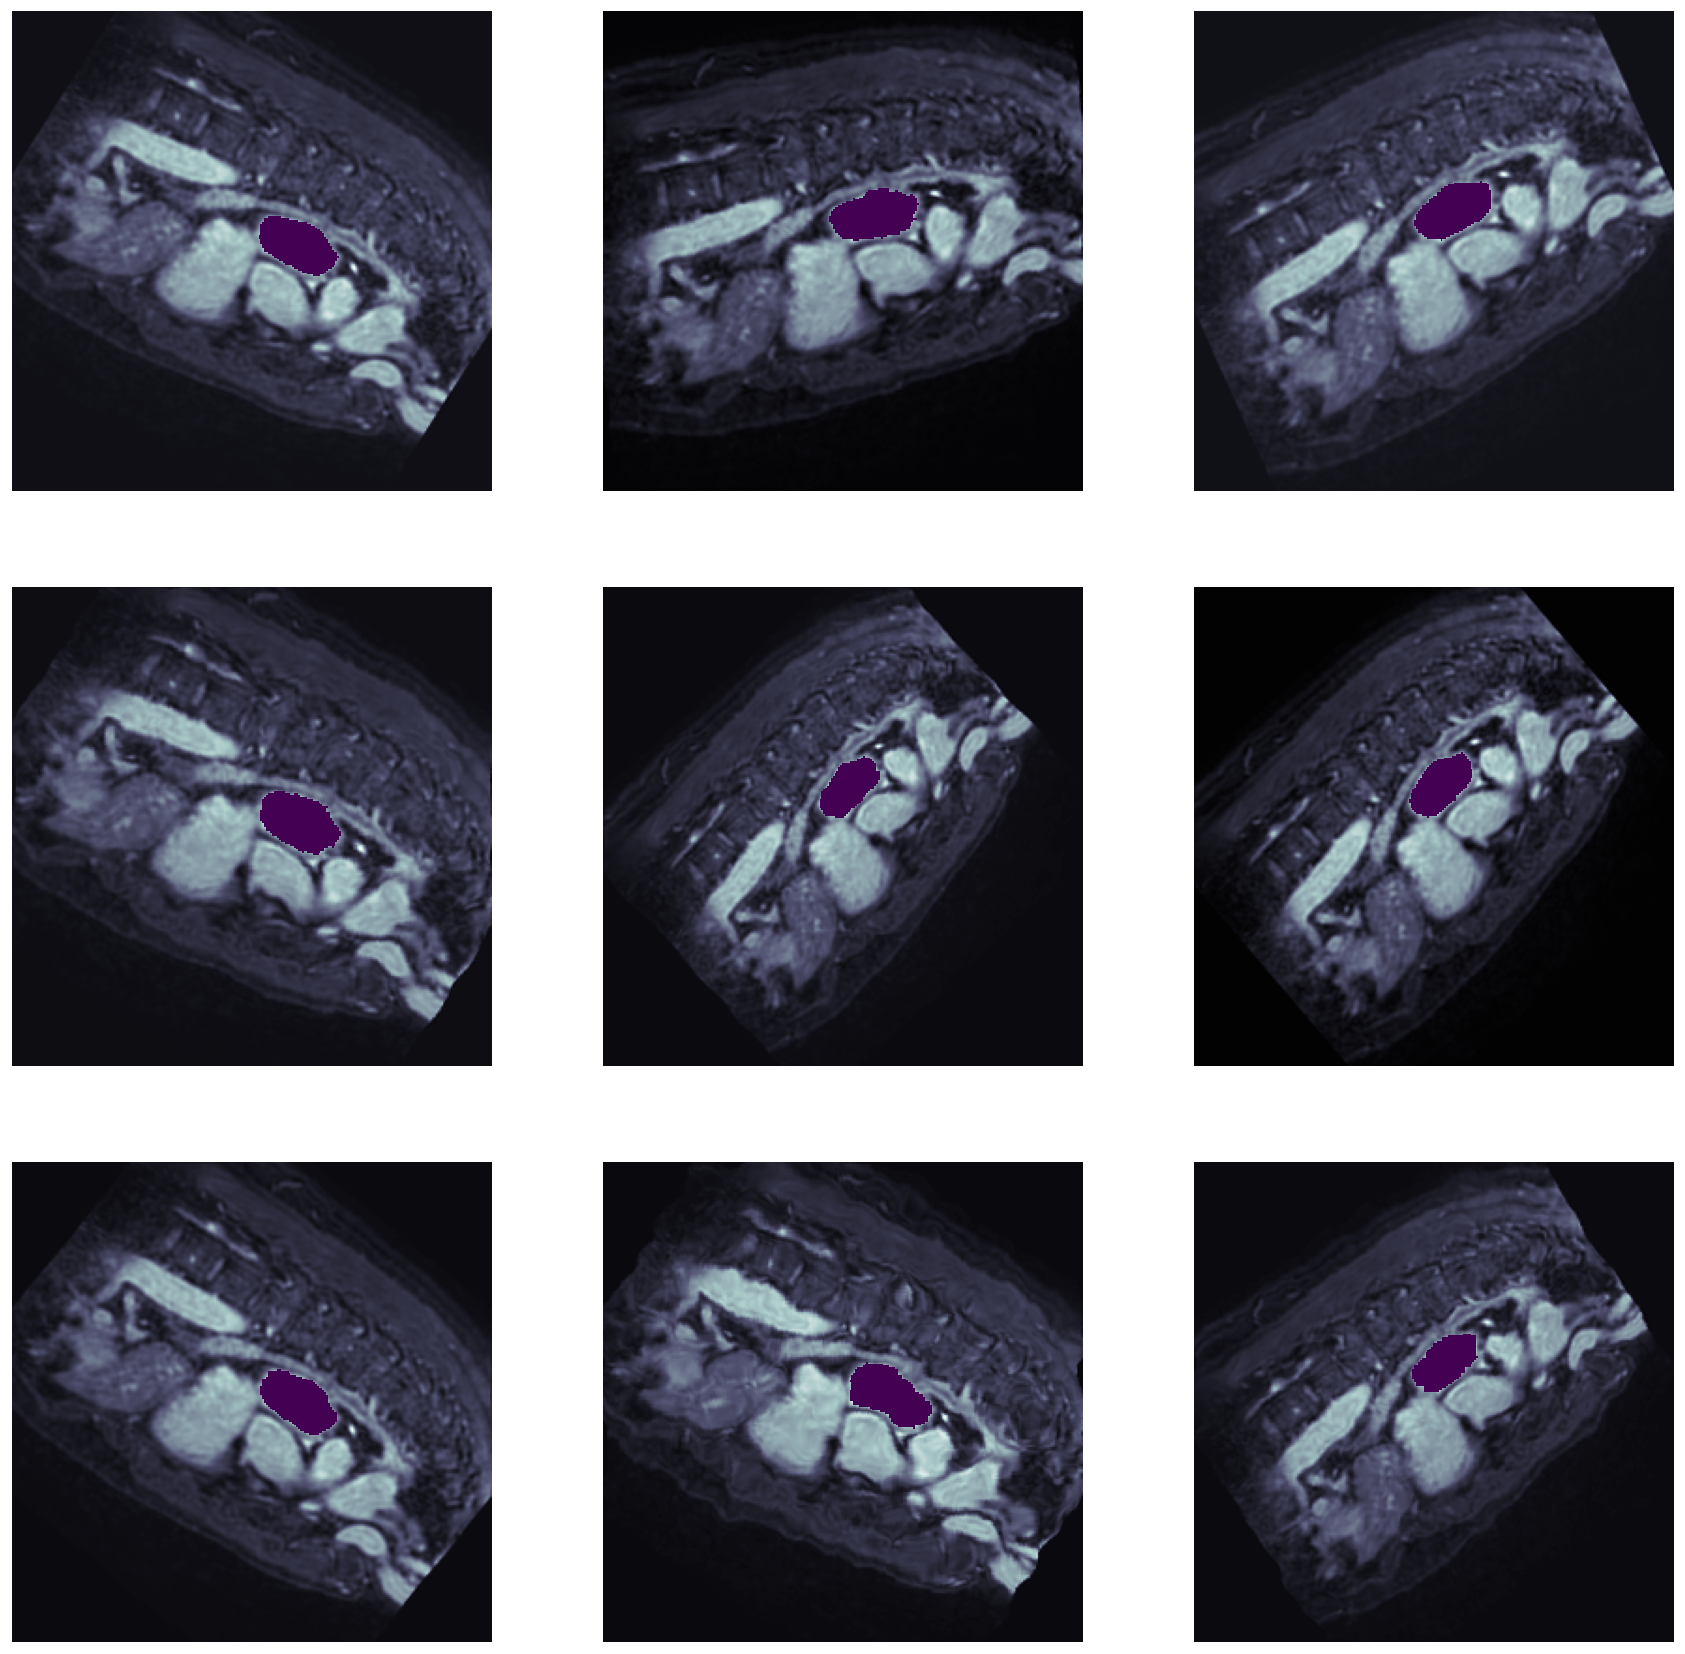

In [20]:
fig, axis = plt.subplots(3, 3, figsize=(18, 18), dpi=120)
for i in range(3):
  for j in range(3):
    slice, mask = dataset[80]
    mask_ = np.ma.masked_where(mask==0, mask)
    axis[i][j].imshow(slice[0], cmap='bone')
    axis[i][j].imshow(mask_[0])
    axis[i][j].axis('off')

# 3.1- Train/Data Loading

In [6]:
train_path = Path('Preprocessed/train/')
val_path   = Path('Preprocessed/val/')

train_dataset = CardiacDataset(train_path, seq)
val_dataset   = CardiacDataset(val_path, None)

In [7]:
batch_size  = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

val_loader   = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=False)

In [8]:
class DiceLoss(torch.nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, pred, mask):
    pred = torch.flatten(pred)
    mask = torch.flatten(mask)

    counter = (pred * mask).sum()
    denum   = pred.sum() + mask.sum() + 1e-8
    dice    = (2 * counter) / denum
    
    return 1 - dice

# 3.2- Train/Model Creation

In [9]:
class AtriumSegmentation(pl.LightningModule):

  def __init__(self):
    super().__init__()

    self.model = UNet()

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    self.loss_fn   = DiceLoss()


  def forward(self, data):
    return torch.sigmoid(self.model(data))


  def training_step(self, batch, batch_idx):
    mri, mask = batch
    mask = mask.float()
    pred = self(mri)

    loss = self.loss_fn(pred, mask)

    self.log('Train Dice', loss)

    if batch_idx % 50 == 0:
      self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Train')
    
    return loss


  def validation_step(self, batch, batch_idx):
    mri, mask = batch
    mask = mask.float()
    pred = self(mri)

    loss = self.loss_fn(pred, mask)

    self.log('Val Dice', loss)

    if batch_idx % 2 == 0:
      self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Val')
    
    return loss


  def log_images(self, mri, pred, mask, name):
    
    pred = pred > 0.5

    fig, axis = plt.subplots(1, 2)

    axis[0].imshow(mri[0][0], cmap='bone')
    mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
    axis[0].imshow(mask_, alpha=0.6)

    axis[1].imshow(mri[0][0], cmap='bone')
    mask_ = np.ma.masked_where(mask[0][0] == 0, pred[0][0])
    axis[1].imshow(mask_, alpha=0.6)

    self.logger.experiment.add_figure(name, fig, self.global_step)


  def configure_optimizers(self):
    return [self.optimizer]

In [10]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [11]:
checkpoint_callback = ModelCheckpoint(monitor='Val Dice',
                                      save_top_k=10,
                                      mode='min')

trainer = pl.Trainer(gpus=1,
                     #logger=TensorBoardLogger('./logs'),
                     #log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# 4- Evaluation

In [13]:
model = AtriumSegmentation.load_from_checkpoint("lightning_logs/version_1/checkpoints/epoch=4-step=1260.ckpt")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [14]:
preds  = []
labels = []

for slice, label in tqdm(val_dataset):
  slice = torch.tensor(slice).to(device).unsqueeze(0)
  with torch.no_grad():
    pred = model(slice)
  preds.append(pred.cpu().numpy())
  labels.append(label)
  
preds  = np.array(preds)
labels = np.array(labels)

  0%|          | 0/360 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [15]:
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.6821)

In [17]:
subject = 'imagesTs/la_002.nii.gz'
subject_mri = nib.load(subject).get_fdata()

subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [19]:
preds = []

for i in range(standardized_scan.shape[-1]):
  slice = standardized_scan[:, :, i]
  with torch.no_grad():
    pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
    pred = pred > 0.5
  preds.append(pred.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
  plt.imshow(standardized_scan[:, :, i], cmap='bone')
  mask = np.ma.masked_where(preds[i] == 0, preds[i])
  plt.imshow(mask, alpha=0.5)
  camera.snap()

animation = camera.animate()

In [21]:
HTML(animation.to_html5_video())

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
